In [71]:
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
import tensorflow as tf
#Function import
from ipynb.fs.full.autoXRD import normdata
from ipynb.fs.full.autoXRD import normdatasingle
from ipynb.fs.full.autoXRD import augdata
from ipynb.fs.full.autoXRD import exp_augdata
from ipynb.fs.full.autoXRD import exp_data_processing

In [58]:
theor = pd.read_csv('Datasets/theor_PbI.csv', index_col=0)
print(theor.shape)
theor = theor.iloc[1:,]
theor_arr = theor.values
print(theor_arr.shape)

# Normalize data for training
ntheor = normdata(theor_arr)

#exp = pd.read_csv('Datasets/exp.csv', index_col=0)
#exp_arr = exp.values
#print(exp_arr.shape)

(2402, 960)
(2401, 960)


In [59]:
label_theo = pd.read_csv('Datasets/label_theo_PbI.csv', header=None, index_col=0)
label_theo = label_theo[1].tolist()

# Load experimental class labels
#label_exp= pd.read_csv('Datasets/label_theo.csv', index_col=0).values
#label_exp = label_exp.reshape([len(label_exp),])

space_group_enc = pd.read_csv('Datasets/encoding.csv', index_col=0)
space_group_enc = list(space_group_enc['0'])

# Enconde theoretical labels
label_t=np.zeros([len(label_theo),])
for i in range(len(label_theo)):
    label_t[i]=space_group_enc.index(label_theo[i])
    
print(label_t.shape)

(480,)


In [60]:
#prepare X et Y
X_th = np.transpose(ntheor)
X_th = X_th.reshape(len(label_theo), 2401, 1)
Y_th = label_t

X_th = X_th.astype(np.float32)
Y_th = Y_th.astype(np.float32)

print(X_th.shape)
print(Y_th.shape)

(480, 2401, 1)
(480,)


In [45]:
# Introduction de set de test à partir de la base de données
# Definition du set de test 20% d'images random
# Avec cette ligne on definit set de images et targets pour l'entrainement et test
X_th_train, X_th_valid, Y_th_train, Y_th_valid = train_test_split(X_th, Y_th, test_size=0.2, random_state=1)

print("X_th_train", X_th_train.shape)
print("X_th_valid", X_th_valid.shape)

print("Y_th_train", Y_th_train.shape)
print("Y_th_valid", Y_th_valid.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_th, Y_th))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_th_valid, Y_th_valid))

print(train_dataset)
print(valid_dataset)

X_th_train (384, 2401, 1)
X_th_valid (96, 2401, 1)
Y_th_train (384,)
Y_th_valid (96,)
<TensorSliceDataset shapes: ((2401, 1), ()), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((2401, 1), ()), types: (tf.float32, tf.float32)>


In [46]:
# Iter in the dataset with a number of epoch and batch size
epoch = 1
batch_size = 32
for X_th_batch, Y_th_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(X_th_batch.shape, Y_th_batch.shape)
    break

(32, 2401, 1) (32,)


In [47]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        # Convolutions
        self.conv1 = tf.keras.layers.Conv1D(32, 8, activation='relu', name="conv1")
        self.conv2 = tf.keras.layers.Conv1D(64, 5, activation='relu', name="conv2")
        self.conv3 = tf.keras.layers.Conv1D(128, 3, activation='relu', name="conv3")
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name="flatten")       
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation='relu', name="d1")
        self.out = tf.keras.layers.Dense(4, activation='softmax', name="output")

    def call(self, X_th):
        conv1 = self.conv1(X_th)
        #print(conv1)
        conv2 = self.conv2(conv1)
        #print(conv2)
        conv3 = self.conv3(conv2)
        #print(conv3)
        flatten = self.flatten(conv3)
        #print(flatten)
        d1 = self.d1(flatten)
        #print(d1)
        output = self.out(d1)
        return output

model = ConvModel()
#model.predict(X_th[:,:,:])

In [48]:
#Define loss, optimizer, accuracy for th emodel to compile
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Loss
train_loss = tf.keras.metrics.Mean(name='train_loss')
valid_loss = tf.keras.metrics.Mean(name='valid_loss')
# Accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='valid_accuracy')

In [49]:
# Definition de la fonction qui va entrainer le modele
# On utilise un graphe @
@tf.function
def train_step(X_th, Y_th):
    # Calcul du gradient
    with tf.GradientTape() as tape:
        # Make a prediction on all the batch
        predictions = model(X_th)
        # Get the error/loss on these predictions
        loss = loss_object(Y_th, predictions)
    # Compute the gradient which respect to the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Change the weights of the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # The metrics are accumulate over time. You don't need to average it yourself.
    train_loss(loss)
    train_accuracy(Y_th, predictions)

In [50]:
# Methode de validation en mode graphe
@tf.function
def valid_step(X_th, Y_th):
    predictions = model(X_th)
    t_loss = loss_object(Y_th, predictions)
    # Set the metrics for the test
    valid_loss(t_loss)
    valid_accuracy(Y_th, predictions)

In [51]:
#Iteration du modele
epoch = 10
batch_size = 10
b = 0 #Compter les batchs
for epoch in range(epoch):
    # Training set
    for X_th_batch, Y_th_batch in train_dataset.batch(batch_size): #Iteration dans la dataset
        train_step(X_th_batch, Y_th_batch) #On lance un entrainement
        template = '\r Batch {}/{}, Loss: {}, Accuracy: {}'
        print(template.format(
            b, len(Y_th), train_loss.result(), 
            train_accuracy.result()*100
        ), end="") #Informations de l'entrainement
        b += batch_size
    # Validation set
    for X_th_batch, Y_th_batch in valid_dataset.batch(batch_size):
        valid_step(X_th_batch, Y_th_batch) #Mesure precision sur chacun des batch

    template = '\nEpoch {}, Valid Loss: {}, Valid Accuracy: {}'
    print(template.format(
        epoch+1,
        valid_loss.result(), 
        valid_accuracy.result()*100)
    )
    #A la fin de chaque epoch on vide
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_accuracy.reset_states()
    train_loss.reset_states()

 Batch 470/480, Loss: 1.1182827949523926, Accuracy: 65.208335876464844
Epoch 1, Valid Loss: 0.5317953824996948, Valid Accuracy: 82.29167175292969
 Batch 950/480, Loss: 0.6518492698669434, Accuracy: 79.58333587646484
Epoch 2, Valid Loss: 0.2941164970397949, Valid Accuracy: 86.45832824707031
 Batch 1430/480, Loss: 0.3531312644481659, Accuracy: 88.750635375976564
Epoch 3, Valid Loss: 0.1629956066608429, Valid Accuracy: 93.75
 Batch 1910/480, Loss: 0.24236106872558594, Accuracy: 91.87512554931646
Epoch 4, Valid Loss: 0.04186036065220833, Valid Accuracy: 100.0
 Batch 2390/480, Loss: 0.10803785175085068, Accuracy: 96.04166412353516
Epoch 5, Valid Loss: 0.02063530497252941, Valid Accuracy: 100.0
 Batch 2870/480, Loss: 0.10802500694990158, Accuracy: 96.25021179199219
Epoch 6, Valid Loss: 0.014056814834475517, Valid Accuracy: 100.0
 Batch 3350/480, Loss: 0.023753715679049492, Accuracy: 99.16666412353516
Epoch 7, Valid Loss: 0.0007092502783052623, Valid Accuracy: 100.0
 Batch 3830/480, Loss: 0.0

In [53]:
res = model.predict(X_th[:,:,:])
print(res.shape)
for i in range(12, 55):
    print(res[i], label_theo[i])

(480, 4)
[9.9901807e-01 9.5626578e-04 2.5267755e-05 3.9408604e-07] 0D
[6.0182247e-05 9.9723607e-01 2.6541273e-03 4.9648628e-05] 1D
[8.2075632e-05 9.9321574e-01 6.4696562e-03 2.3255084e-04] 1D
[8.9065472e-15 1.0000000e+00 5.9758249e-14 6.9064547e-16] 1D
[9.9999022e-01 9.5860760e-06 2.0216147e-07 4.5908464e-12] 0D
[2.2680488e-23 8.3043530e-14 1.0000000e+00 1.8605083e-11] 2D
[1.6667742e-03 9.9814987e-01 1.4835047e-04 3.5008827e-05] 1D
[8.5635584e-06 9.9999022e-01 1.1658947e-06 9.6498634e-13] 1D
[1.3838549e-07 3.1600868e-07 9.9999118e-01 8.3780778e-06] 2D
[1.0060014e-05 6.9616258e-06 9.9996734e-01 1.5579544e-05] 2D
[2.7449547e-08 5.5043761e-06 9.9999344e-01 1.0676674e-06] 2D
[1.6819775e-05 9.9968815e-01 1.9643514e-04 9.8714940e-05] 1D
[7.3563665e-06 9.9966049e-01 2.2401294e-04 1.0810225e-04] 1D
[2.5286590e-06 9.9971181e-01 2.7510079e-04 1.0605670e-05] 1D
[2.0827624e-13 3.0366522e-08 1.0000000e+00 1.0613558e-08] 2D
[6.1374521e-07 1.8901444e-07 9.9994957e-01 4.9603776e-05] 2D
[9.5887437e-11 

(4305, 136)


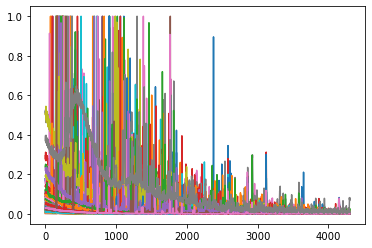

(4305, 68)
(68, 4305, 1)


In [68]:
#Load experimental data as dataframe
exp = pd.read_csv('Datasets/exp.csv', index_col=0)
exp_arr = exp.values
print(exp_arr.shape)

#Normalisation
nexp = normdata(exp_arr)
plt.plot(nexp)
plt.show()
print(nexp.shape)

# Process data experimental
# Define spectral range for data augmentation
exp_min = 0
exp_max = 2401 
theor_min = 125

#window size for experimental data extraction
window = 20
theor_max = theor_min+exp_max-exp_min

# Preprocess experimental data
#post_exp = normdatasingle(exp_data_processing (nexp, exp_min, exp_max, window))
#plt.plot(post_exp)
#plt.show()

#print(post_exp.shape)
# Specify how many data points we augmented
#th_num = 734

# Augment data, this may take a bit
#augd,pard,crop_augd = augdata(ntheor, th_num, label_theo, theor_min, theor_max)

#prepare arrays
X_exp = np.transpose(nexp)
X_exp = X_exp.reshape(68, 4305, 1)

print(X_exp.shape)

X_exp = X_exp.astype(np.float32)

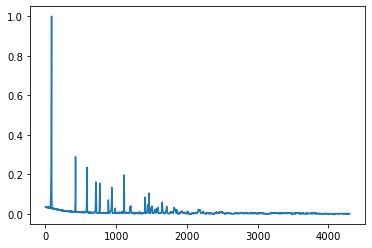

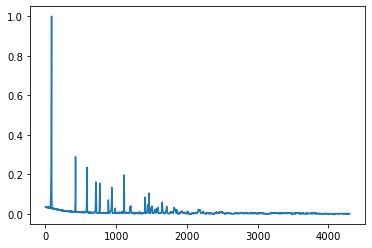

In [69]:
plt.plot(nexp[:,31])
plt.show()
plt.plot(X_exp[31,:])
plt.show()

In [70]:
model.predict(X_exp[:,:,:])

ValueError: Input 0 of layer d1 is incompatible with the layer: expected axis -1 of input shape to have value 305664 but received input with shape [None, 549376]